In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import sys

%matplotlib inline

In [12]:
def psi_(x_space,y_space,x_0,y_0,theta,sigma):
    angle = np.array([np.cos(theta),np.sin(theta)])
    xy = lambda x,y: np.array([x,y])
    gaussian = lambda xy: np.exp(-(np.dot(xy,xy))/(2.*sigma**2))
    phase = lambda xy: np.exp((1.j*np.pi*np.dot(angle,xy))/(2.*sigma))
    phase_conj = lambda xy: np.exp(-(1.j*np.pi*np.dot(angle,xy))/(2*sigma))
    
    #c2 normalization formula
    numerator = 0
    denominator = 0
    
    for i in xrange(x_space):
        for j in xrange(y_space):
            denominator += gaussian(xy(i-x_0,j-y_0))
            numerator += gaussian(xy(i-x_0,j-y_0))*phase(xy(i-x_0,j-y_0))
    c2 = numerator/denominator
    
    #c1 normalization formula
    norm = 0
    psi = lambda xy: (1./sigma)*(phase(xy) - c2)*gaussian(xy)
    psi_conj = lambda xy: (1./sigma)*(phase_conj(xy) - c2)*gaussian(xy)
    
    for i in xrange(x_space):
        for j in xrange(y_space):
            norm += psi_conj(xy(i-x_0,j-y_0))*psi(xy(i-x_0,j-y_0))
    c1 = 1./np.sqrt(norm)
    
    space = np.zeros((x_space,y_space),dtype=complex)
    
    for i in xrange(x_space):
        for j in xrange(y_space):
            space[i][j] = c1 * psi(xy(i-x_0,j-x_0))
    
    
    return space
    

(13, 13)


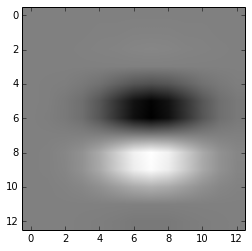

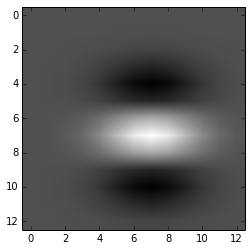

(13, 13)


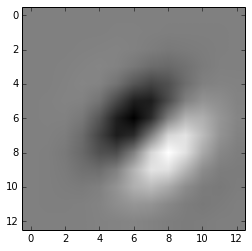

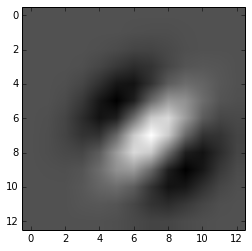

(13, 13)


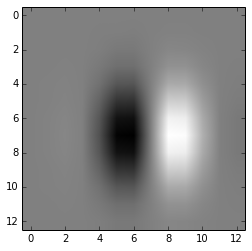

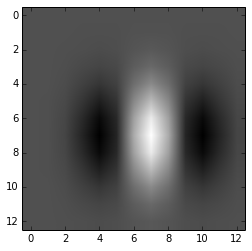

(13, 13)


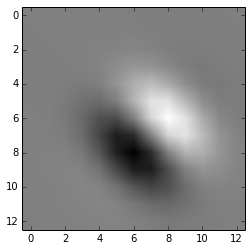

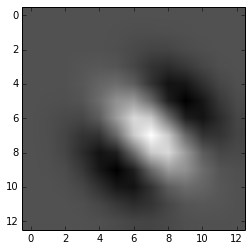

In [13]:
out = []
for i in [2]:
    for j in [0, np.pi/4., np.pi/2., 3.*np.pi/4]:
        psi = psi_(13,13,7,7,j,i)
        print psi.shape
        out.append(psi)
        plt.imshow(psi.imag,cmap="gray")
        plt.show()
        plt.imshow(psi.real,cmap="gray")
        plt.show()

In [14]:
def mapping(matrix):
    max_val = 0
    min_val = 0
    for i in matrix:
        if max(i) > max_val:
            max_val = max(i)
        if min(i) < min_val:
            min_val = min(i)
    map_ = interp1d([min_val,max_val],[0,256])
    return map_(matrix)

In [15]:
#visual = mapping(out)
#cv2.imshow("image",visual.imag)
#cv2.imwrite("image.jpg",visual.imag)

In [16]:
image = cv2.imread("right.png",0)
convolved = []
for psi in out:
    convolved.append(signal.convolve2d(image,psi))


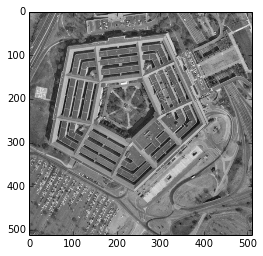

In [17]:
plt.imshow(image,cmap="gray")

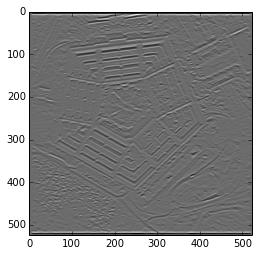

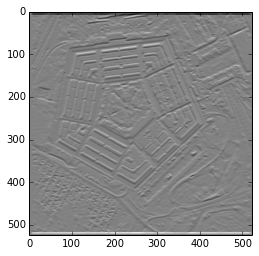

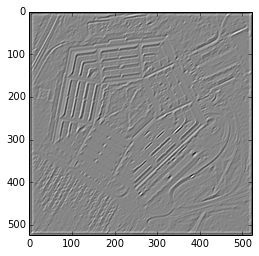

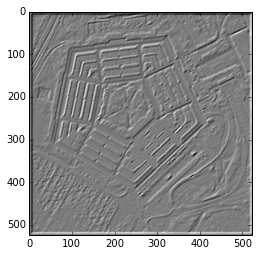

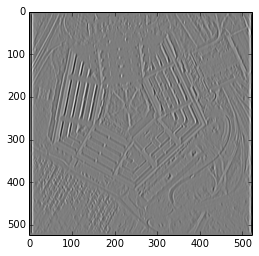

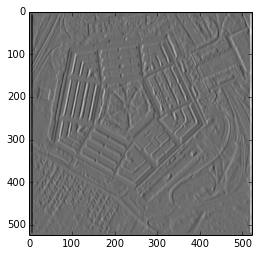

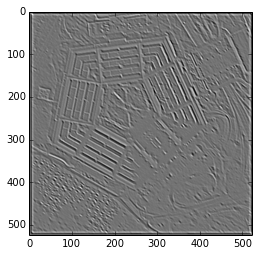

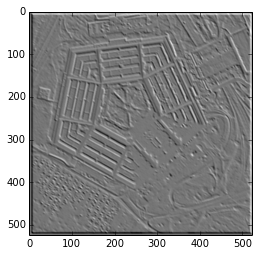

In [18]:
for i in convolved:
    plt.imshow(i.real,cmap="gray")
    plt.show()
    plt.imshow(i.imag,cmap="gray")
    plt.show()

In [19]:
#calculate maxima for the different angles
def maxmin(image, convolved):
    max_array = np.zeros((len(image)+12,len(image[0])+12)) #padding

    #for i in xrange(len(max_array)):
    #    for j in xrange(len(max_array[0])):
    #        max_array[i][j] = 0 + 0j

    for i in convolved:
        max_array = np.maximum(np.abs(i.imag - i.real),np.abs(max_array))
        #max_array = i.imag + max_array
    return max_array

max_array = maxmin(image, convolved)

Homework Image


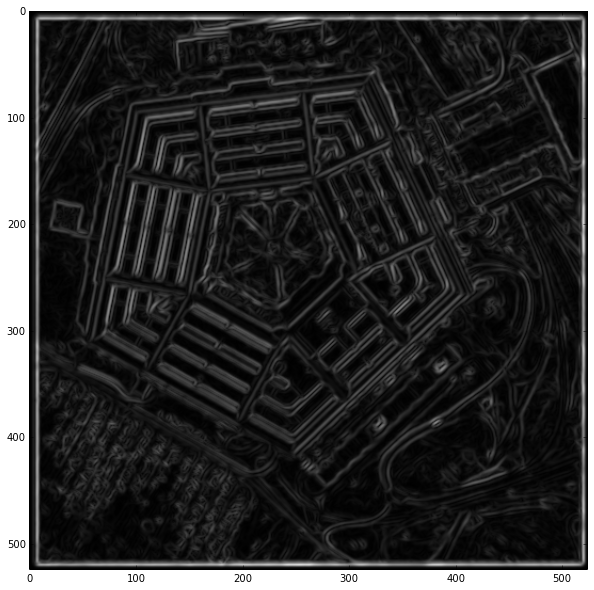

In [20]:
plt.figure(figsize=(10,10))
print "Homework Image"
plt.imshow(max_array,cmap="gray")
plt.savefig("right_contrast.jpg")


In [21]:
l_image = cv2.imread("left_contrast.jpg",0)
r_image = cv2.imread("right_contrast.jpg",0)

In [ ]:
def error(left, right, x_0, y_0, d_0, width, epsilon=0.001):
    s = 0
    for i in xrange(x_0-width, x_0+width):
        val1 = (left[i][y_0]+epsilon)/(right[i-d_0][y_0]+epsilon)
        val2 = (right[i-d_0][y_0]+epsilon)/(left[i][y_0]+epsilon)
        s += val1
        s += val2
    return s

In [ ]:
disp_array = np.zeros(max_array.shape)
err_array = np.zeros(max_array.shape)+sys.maxint

for i in xrange(30,len(max_array)-30):
    for j in xrange(30,len(max_array[0])-30):
        for k in xrange(-5,15):
            loc_error = error(l_image,r_image,i,j,k,5)
            if loc_error < err_array[i][j]:
                err_array[i][j] = loc_error
                disp_array[i][j] = k
                

In [ ]:
plt.imshow(disp_array)

In [ ]:
def gauss_blur(x_dim, y_dim, x_0, y_0, sigma): 
    xy = lambda x,y: np.array([x,y])
    gaussian = lambda xy: np.exp(-np.dot(xy,xy)/(2*sigma**2))
    
    #normalization
    sum = 0
    for i in xrange(x_dim):
        for j in xrange(y_dim):
            sum+= gaussian(xy(i-x_0,j-y_0))
    c=1./sum
    
    matrix = np.zeros((x_dim,y_dim))
    for i in xrange(x_dim):
        for j in xrange(y_dim):
            matrix[i][j] = c*gaussian(xy(i-x_0,j-y_0))
    
    return matrix
    
blurred = signal.convolve2d(image,gauss_blur(37,37,19,19,2))
plt.imshow(blurred,cmap="gray")

In [ ]:
#creating a histogram of intensity vs count
def intensity(max_array, n):
    bins = np.linspace(np.amin(max_array),np.amax(max_array),num=n,endpoint=True)
    count = np.zeros(len(bins))
    for i in xrange(len(max_array)):
        for j in xrange(len(max_array[0])):
            intensity_bin = 0
            for k in xrange(len(bins)):
                if k == len(bins)-1:
                    intensity_bin = k-1
                    break
                if max_array[i][j] > bins[k] and max_array[i][j] < bins[k+1]:
                    intensity_bin = k
                    break
            count[intensity_bin] += 1
    plt.plot(bins,count)

intensity(max_array.real,100)
plt.show()
intensity(max_array.imag,100)
plt.show()
intensity(image,100)
intensity(blurred,100)
plt.ylim(0,2000)
plt.show()

In [ ]:
def ratio(max_array, epsilon):
    r = (max_array.real + 0.001*epsilon)/(max_array.imag + epsilon)
    return r

def edge_ratio(max_array, epsilon):
    r = ratio(max_array, epsilon)
    d = np.amax(r)
    edge = 1. - (r/d)
    return edge

def diff(max_array, beta):
    c = np.amax(max_array.imag)
    d = max_array.real - beta*(max_array.imag - c)
    return d

def edge_diff(max_array, alpha, beta):
    edge = np.exp(-alpha*diff(max_array, beta))
    return edge



plt.imshow(edge_ratio(max_array,100),cmap="gray")
plt.show()
plt.imshow(edge_diff(max_array,.01,.01),cmap="gray") #alha seems to determine , beta seems to determine roughness
plt.show()
a = np.maximum(edge_ratio(max_array,.01),edge_diff(max_array,.01,.01))
plt.imshow(a,cmap="gray")
plt.show()
plt.imshow(image,cmap="gray")
plt.show()

In [ ]:
from scipy import optimize